In [2]:
# import what you need ! 

import sys
sys.path.append('../2_modules/')

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import subprocess as sp
from subprocess import Popen

# our modules: 
import notepicker
import makeDataChord_v2 as mDc
import writeCmixSco_GRAN_v2 as wRT_gran
# import writeCmixSco_WT_ac as wRT_wt
# _ac stands for autocheck

%matplotlib inline

# ======================================================
# autocheck for your RTcmix installation type: 
cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
if cmixStatus == 0:
    cmixInstalled = True
    print("CMIX found.")
else:
    cmixInstalled = False
    print("CMIX not found, using pyGoRTcmix instead.")
# ======================================================

%matplotlib inline

CMIX found.


# ================================================
## READ IN THE DATA ! 

In [10]:
# READ IN THE DATA FILE ! ! !
#datafilename = '../0_data_examples/breathalyzer/BA_ben_1.pkl'
datafilename = '../0_data_nogit/pizzadevils_120s.pkl'
breath = pd.read_pickle(datafilename) # np.loadtxt(datafilename)
print(breath[0:5])
time = np.array(breath.time_s)
p1 = temp_C = np.array(breath.temp_C)
p2 = humidity = np.array(breath.hum)

# put the data into a dictionary: 
# (very useful, but we will also work with pandas)
data_dict = {}
data_dict['time_o'] = time  # the _o indicates these are the original values, un-re-sampled
data_dict['p1_o'] = p1

      hum  temp_C  time_s
0  30.516   26.78  0.0000
1  29.837   26.78  0.3760
2  29.124   26.79  0.7516
3  28.544   26.79  1.1273
4  28.341   26.80  1.5028


Text(0,0.5,'amplitude [units?]')

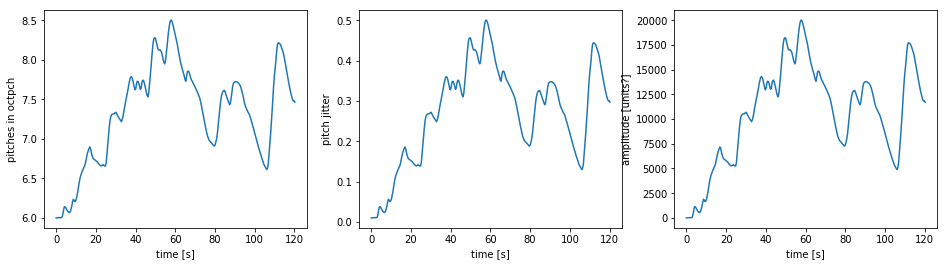

In [11]:
# the gransynth instrument ! 
# http://rtcmix.org/reference/instruments/GRANSYNTH.php

# PITCH 
# using RTcmix linear octaves !
# Linear octaves are similar to octave.pitch-class (oct.pc) notation in that 8.00 is middle C, 
# 9.00 is the C an octave above, etc. The difference is that the fractional part of the specification 
# represents a direct mapping onto the notes of the scale between octaves. For example, in oct.pc notation 
# the value 8.06 represents F-sharp (the tritone, 1/2 the chromatic scale between 8.00 and 9.00). 
# This would be represented as 8.5 in linear octaves. 

# FREQUENCIES
# in 
root_freq = 6.0 # what is the lowest value it can have?
peak_freq = 8.5
p1_scl = np.interp(p1,[min(p1),max(p1)],[root_freq,peak_freq])

# AMPLITUDE
# absolute amplitude (16-bit, 0-32768)
amp_range = [0,20000]
amp = np.interp(p1,[min(p1),max(p1)],amp_range)

# PITCHJITTER
# p13 ("PITCHJITTER") sets the maximum randomly determined amount to add or subtract from the current pitch (in linear octaves).
pitchjtr_range = [0.01,0.5]
pitchjtr = np.interp(p1,[min(p1),max(p1)],pitchjtr_range)


# --======================--
# plotting
# --======================--
plt.figure(figsize=[16,4])

plt.subplot(1,3,1)
plt.plot(time,p1_scl)
plt.xlabel('time [s]')
plt.ylabel('pitches in octpch')

plt.subplot(1,3,2)
plt.plot(time,pitchjtr)
plt.xlabel('time [s]')
plt.ylabel('pitch jitter')

plt.subplot(1,3,3)
plt.plot(time,amp)
plt.xlabel('time [s]')
plt.ylabel('amplitude [units?]')


# =============================================
## 2) Granular Synthesis ! 

In [5]:
#create RTcmix score
reload(wRT_gran)

tones_dict = {}
#cmixInstalled variable can also be passed to the writeCmixSco module directly from the notebook
tones_dict['cmixInstalled'] = cmixInstalled
tones_dict['base_name'] = 'lern_GRANSYNTH_v1_pitchjitVAR'
tones_dict['dur_sound'] = 16

# time series: 
tones_dict['p1'] = p1_scl
tones_dict['amplitude'] = amp # = np.array([7000])
# add pitchjitter
tones_dict['pitchjitter'] = pitchjtr # np.array([2.0]) # 

# single, constant values
#tones_dict['pitchjitter'] = 2.0 
tones_dict['hopjitter'] = 0.0

wRT_gran.writeCmixSco_GRAN(tones_dict)

dur = 16

317
Amplitude is time varying (p-field)
317
Pitchjitter is time varying (p-field)
CMIX found.
rtoutput("lern_GRANSYNTH_v1_pitchjitVAR.wav")

RTcmix score created.


In [6]:
#play RTcmix score and create a wave file
from subprocess import Popen
import subprocess as sp
import os

#use CMIX if installed; if not, use pyGoRTcmix
if cmixInstalled:
    cmix_cmd = 'CMIX < ' + tones_dict['base_name'] + '.sco'
else:
    cmix_duration = str(tones_dict['dur_sound'])
    cmix_cmd = '../pyGoRTcmix/pyGoRTcmix -inputscore ' + os.path.abspath(tones_dict['base_name'] + '.sco ') + '-output ' + os.path.abspath(tones_dict['base_name'] + '.wav ') +'-dur ' + cmix_duration
print(cmix_cmd)

# NOTE if the file exists already, you *MAY* have to delete it by hand to make a new one. 
# best way is to use sp to check if it is exists, and if so, delete it.

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True

runCMIX.wait()
print('\nhopefully i just wrote your sound file (' + tones_dict['base_name'] + '.wav); is it here?')
! ls *.wav


CMIX < lern_GRANSYNTH_v1_pitchjitVAR.sco

hopefully i just wrote your sound file (lern_GRANSYNTH_v1_pitchjitVAR.wav); is it here?
lern_GRANSYNTH_v1_pitchjitVAR.wav


## ------------------------------------------------------------
## Plot the spectrogram to see effects of GranSynth parameters

0.6.2


(20, 2048)

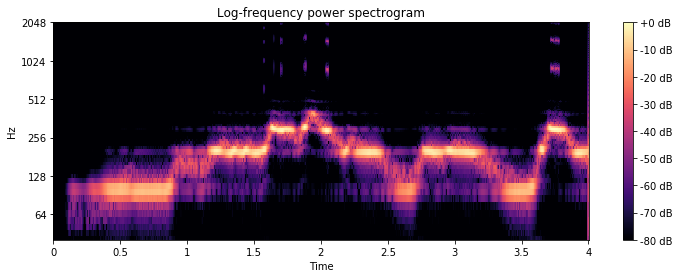

In [7]:
# LOAD THE SOUND FILE
import librosa
print(librosa.__version__)
import librosa.display

filename = tones_dict['base_name'] + '.wav'

y, sr = librosa.load(filename)
y_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max) 

plt.figure(figsize=(12,4))
librosa.display.specshow(y_db, sr=sr, hop_length=128, x_axis='time', y_axis='log') #y_axis='log'
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.ylim([20,2048])

#figname = tones_dict['base_name'] + '.png'
#plt.savefig(figname,dpi=120)

/Users/ben/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


Text(0,0.5,'dB')

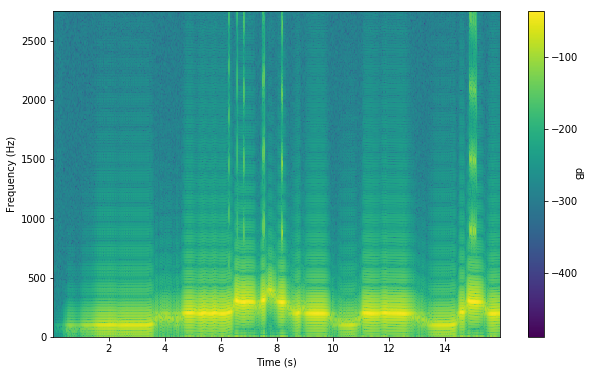

In [8]:
# Or a lower level approach, using scipy, spsig. 

from scipy import signal as spsig

# Compute the spectrogram
NfftSTFT = 4096 # The number of frequency points for the FFT of each frame
SliceLength = int(0.05*sr) # The length of each frame (should be expressed in samples)
Overlap = int(SliceLength/4) # The overlapping between successive frames (should be expressed in samples)
[fSTFT, tSTFT, STFT] = spsig.spectrogram(y, fs=sr, nperseg=SliceLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!

# Plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,sr/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [9]:
sp.run(['mv', tones_dict['base_name'], '../3_output_nogit'])
sp.run('mv *.wav ../3_output_nogit/', shell=True)
sp.run('mv *.sco ../3_output_nogit/', shell=True)
!ls

hidden                            s04_DataDrivenRTcmix.ipynb
s00_make_simple_sounds.ipynb      s05_GranSynth_RTcmix.ipynb
s00_make_simple_sounds.py         s06_Animation1_Breathalyzer.ipynb
s01_DirectSonification.ipynb      s07a_GraphicalElements.ipynb
s01_DirectSonification.py         s07b_GraphicalElements.ipynb
s03_IntroPitchesnScales.ipynb
